<a href="https://colab.research.google.com/github/Darshil420/crop_disease/blob/main/crop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import shutil
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten ,GlobalAveragePooling2D ,BatchNormalization ,Dropout
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import mixed_precision
from tensorflow.keras.optimizers import Adam

In [ ]:

!pip install kaggle -q

from google.colab import files

files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d arjuntejaswi/plant-village

!unzip -q plant-village.zip -d /content/PlantVillage

data_dir = "/content/PlantVillage/PlantVillage"

base_dir = "/content/plant_split"
os.makedirs(base_dir, exist_ok=True)

splits = ["train", "val", "test"]
for split in splits:
    os.makedirs(os.path.join(base_dir, split), exist_ok=True)

for cls in os.listdir(data_dir):
    cls_path = os.path.join(data_dir, cls)
    if not os.path.isdir(cls_path):
        continue

    images = os.listdir(cls_path)
    random.shuffle(images)

    n_total = len(images)
    n_train = int(0.7 * n_total)
    n_val = int(0.15 * n_total)

    train_imgs = images[:n_train]
    val_imgs = images[n_train:n_train+n_val]
    test_imgs = images[n_train+n_val:]

    for split, split_imgs in zip(["train", "val", "test"], [train_imgs, val_imgs, test_imgs]):
        split_cls_path = os.path.join(base_dir, split, cls)
        os.makedirs(split_cls_path, exist_ok=True)
        for img in split_imgs:
            src = os.path.join(cls_path, img)
            dst = os.path.join(split_cls_path, img)
            shutil.copy(src, dst)

print(" Dataset download & split completed!")


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/arjuntejaswi/plant-village
License(s): unknown
 92% 302M/329M [00:00<00:00, 813MB/s] 
100% 329M/329M [00:00<00:00, 815MB/s]
 Dataset download & split completed!


In [ ]:
import os
print("Current directory:", os.getcwd())
print("Files in current directory:", os.listdir('.'))

Current directory: /content
Files in current directory: ['.config', 'plant_split', 'plant-village.zip', 'PlantVillage', 'sample_data']


In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1/255.,
    zoom_range = 0.1,
    shear_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    rotation_range = 25,
    horizontal_flip = True,
    fill_mode = 'nearest'
)
valid_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen  = ImageDataGenerator(rescale=1/255.)

In [ ]:
train_dataset = train_datagen.flow_from_directory(
    os.path.join(base_dir, "train"),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_dataset = valid_datagen.flow_from_directory(
    os.path.join(base_dir, "val"),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_dataset = test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 14440 images belonging to 15 classes.
Found 3089 images belonging to 15 classes.
Found 3109 images belonging to 15 classes.


In [ ]:
dataset_dir = "/content/PlantVillage/PlantVillage"

print(os.path.exists(dataset_dir))

classes = sorted(os.listdir(dataset_dir))
print(f"Found classes: {classes}")

True
Found classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


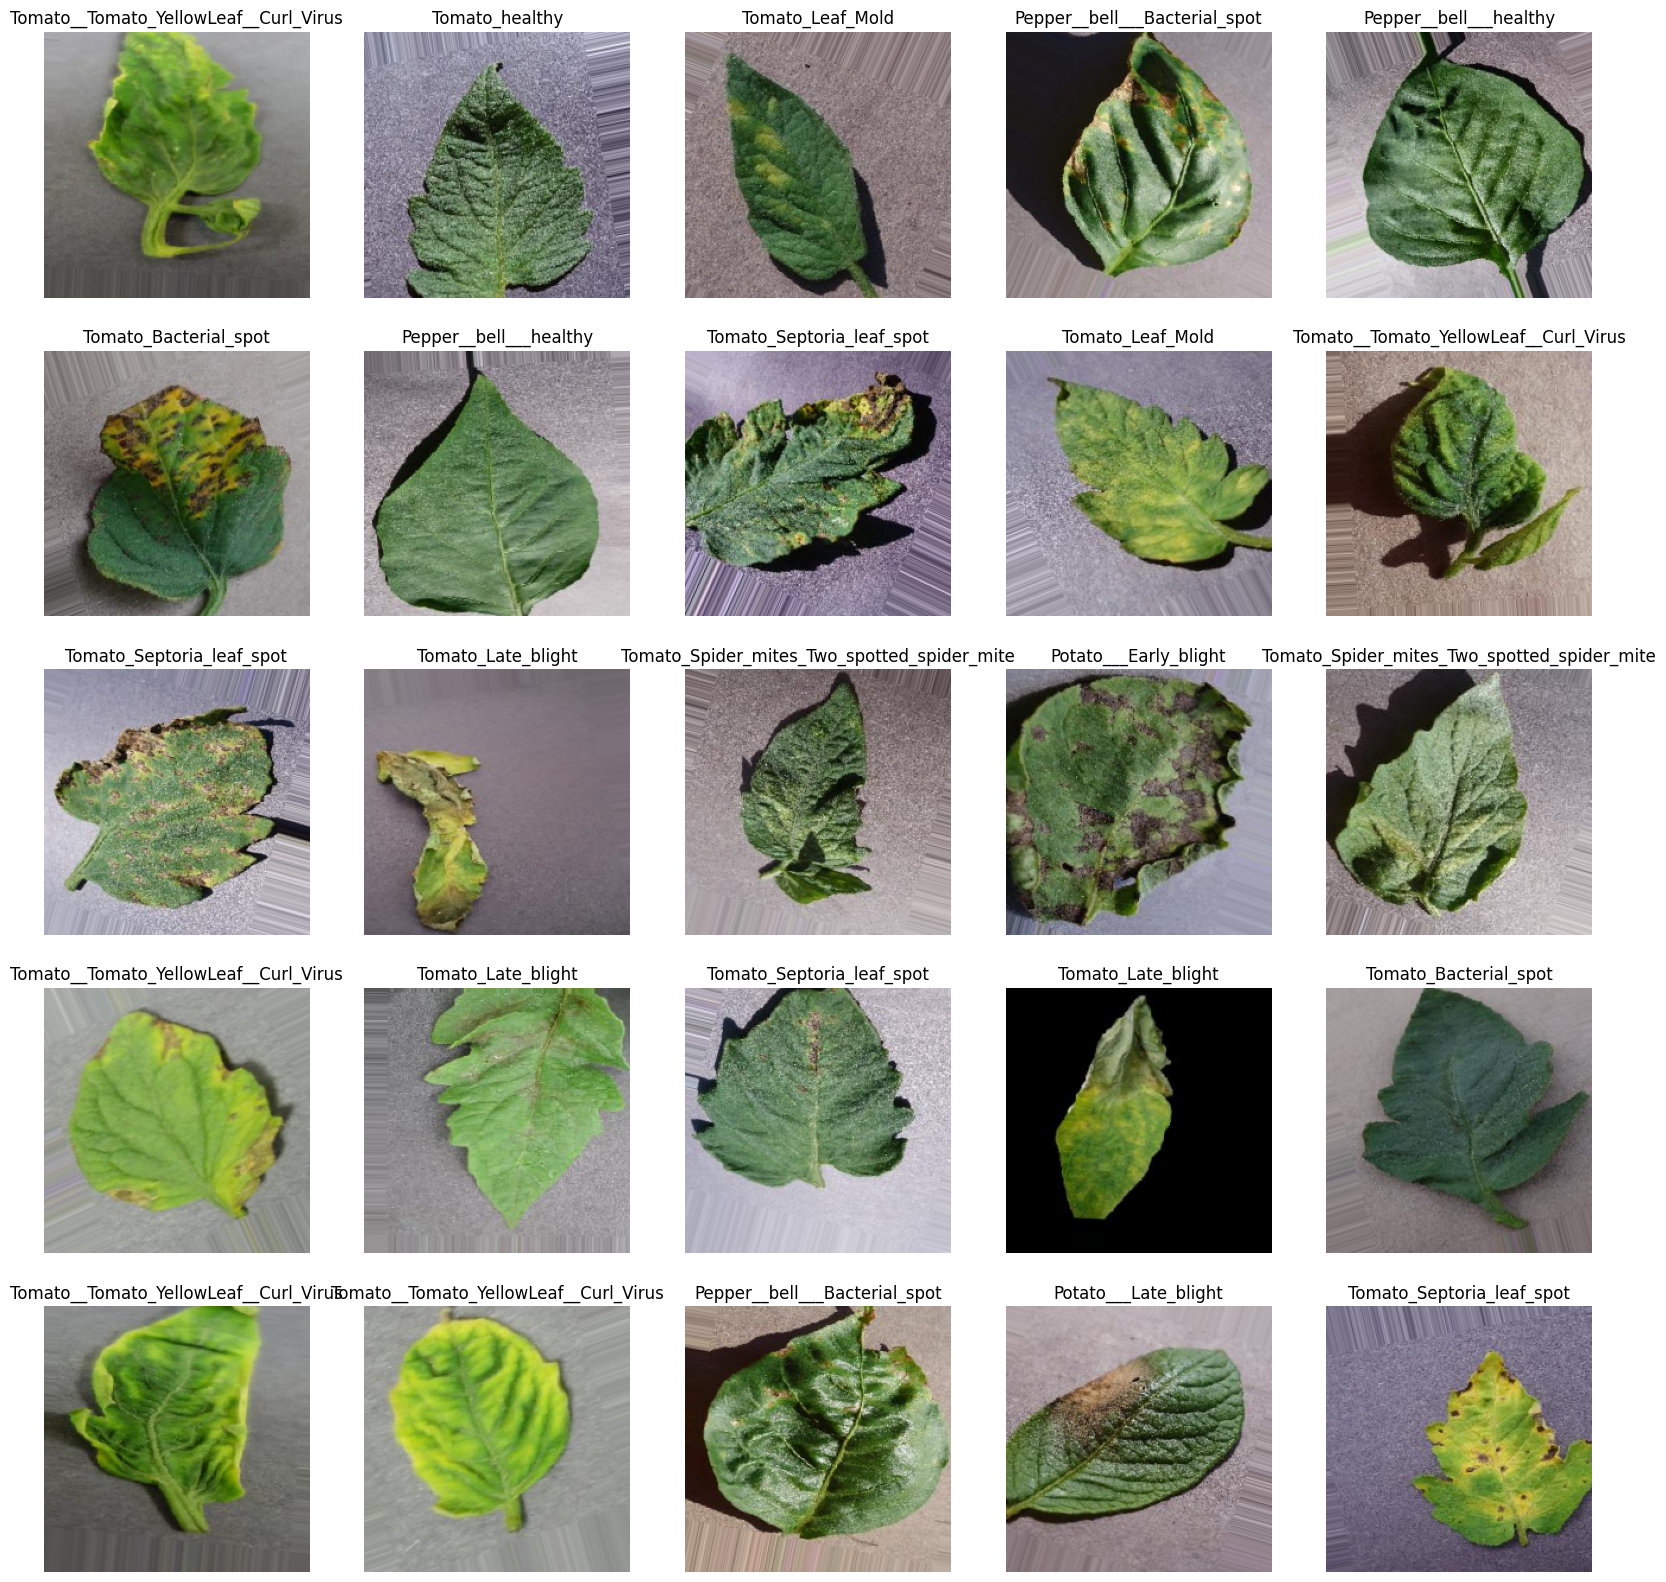

In [ ]:
x_batch, y_batch = next(train_dataset)
random_images = np.random.choice(len(x_batch), 25, replace=False)

plt.figure(figsize=(20, 20))
for n, i in enumerate(random_images):
    plt.subplot(5, 5, n+1)

    plt.imshow((x_batch[i] * 255).astype("uint8"))
    plt.axis('off')
    class_idx = np.argmax(y_batch[i])
    class_name = list(train_dataset.class_indices.keys())[class_idx]
    plt.title(class_name)
plt.show()

12    2245
5     1488
7     1336
9     1239
10    1173
14    1113
1     1034
11     982
2      700
3      700
6      700
0      697
8      666
13     261
4      106
Name: count, dtype: int64


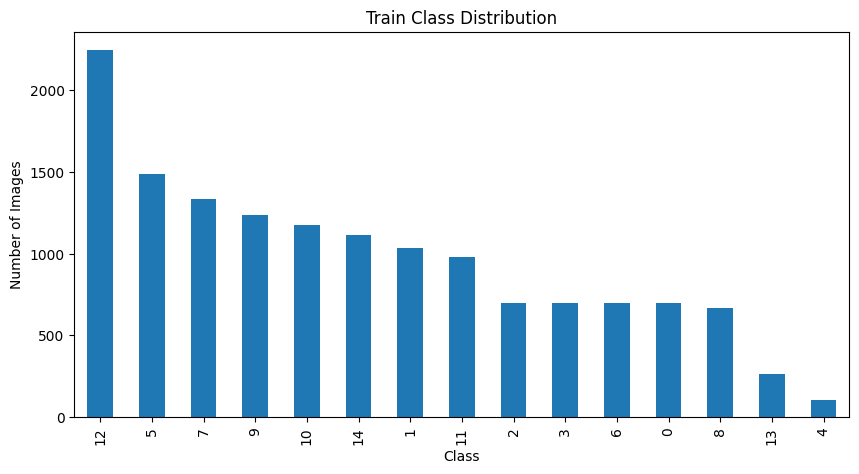

In [ ]:
train_distribution = pd.Series(train_dataset.classes).value_counts()
print(train_distribution)

train_distribution.plot(kind='bar', figsize=(10,5), title="Train Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(768, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dense(15, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 4,758,351 (18.15 MB)

 Trainable params: 2,500,367 (9.54 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('checkpoint.keras', monitor='val_loss', save_best_only=True, mode='min')
history = model.fit(train_dataset, validation_data=val_dataset, epochs=1, callbacks=[earlystopping, learning_rate, checkpoint])

452/452 ━━━━━━━━━━━━━━━━━━━━ 172s 380ms/step - accuracy: 0.9458 - loss: 0.1610 - val_accuracy: 0.9226 - val_loss: 0.2443 - learning_rate: 3.0000e-04


[0.9446675777435303]


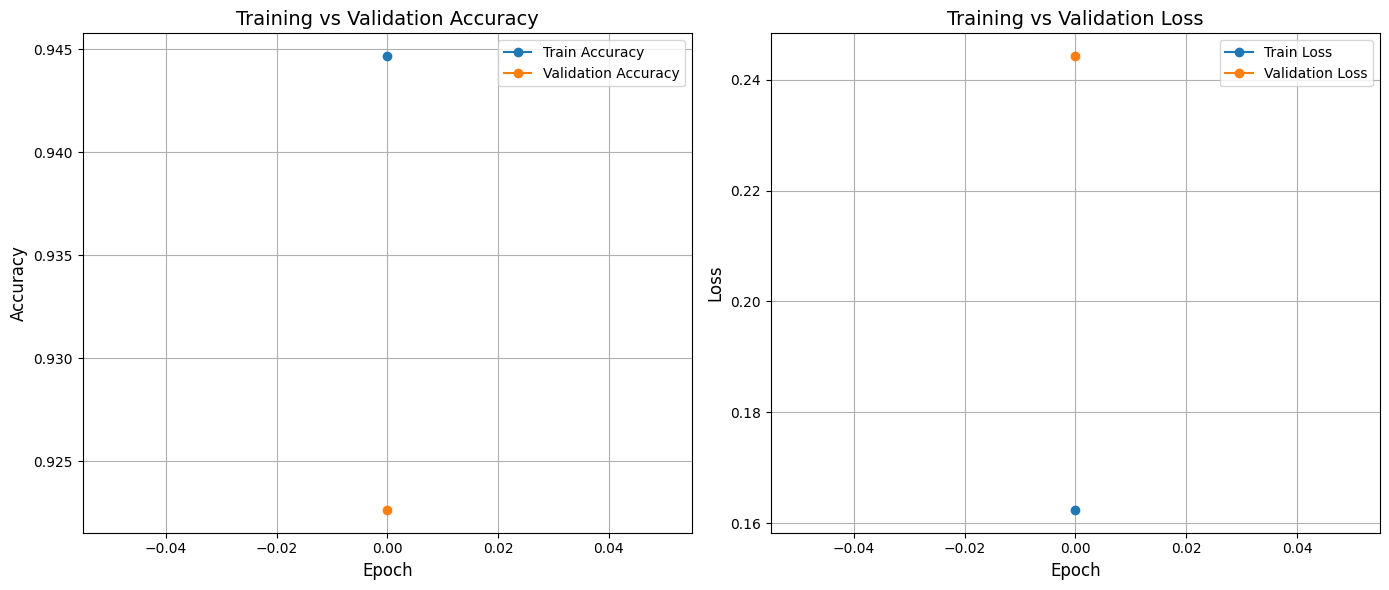

In [ ]:

print(history.history['accuracy'])

plt.figure(figsize=(14,6))


plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], marker='o', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], marker='o', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True)
plt.legend()


plt.subplot(1,2,2)
plt.plot(history.history['loss'], marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', label='Validation Loss')
plt.title('Training vs Validation Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
history.history

loss, acc = model.evaluate(train_dataset)
print("Train Loss:", loss)
print("Train Accuracy:", acc)

loss, acc = model.evaluate(val_dataset)
print("Validation Loss:", loss)
print("Validation Accuracy:", acc)

loss, acc = model.evaluate(test_dataset)
print("Test Loss:", loss)
print("Test Accuracy:", acc)


452/452 ━━━━━━━━━━━━━━━━━━━━ 166s 367ms/step - accuracy: 0.9579 - loss: 0.1189
Train Loss: 0.11909645795822144
Train Accuracy: 0.9586564898490906
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9177 - loss: 0.2650
Validation Loss: 0.24426397681236267
Validation Accuracy: 0.9226287007331848


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


98/98 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 0.9384 - loss: 0.1907
Test Loss: 0.2449285089969635
Test Accuracy: 0.9228047728538513


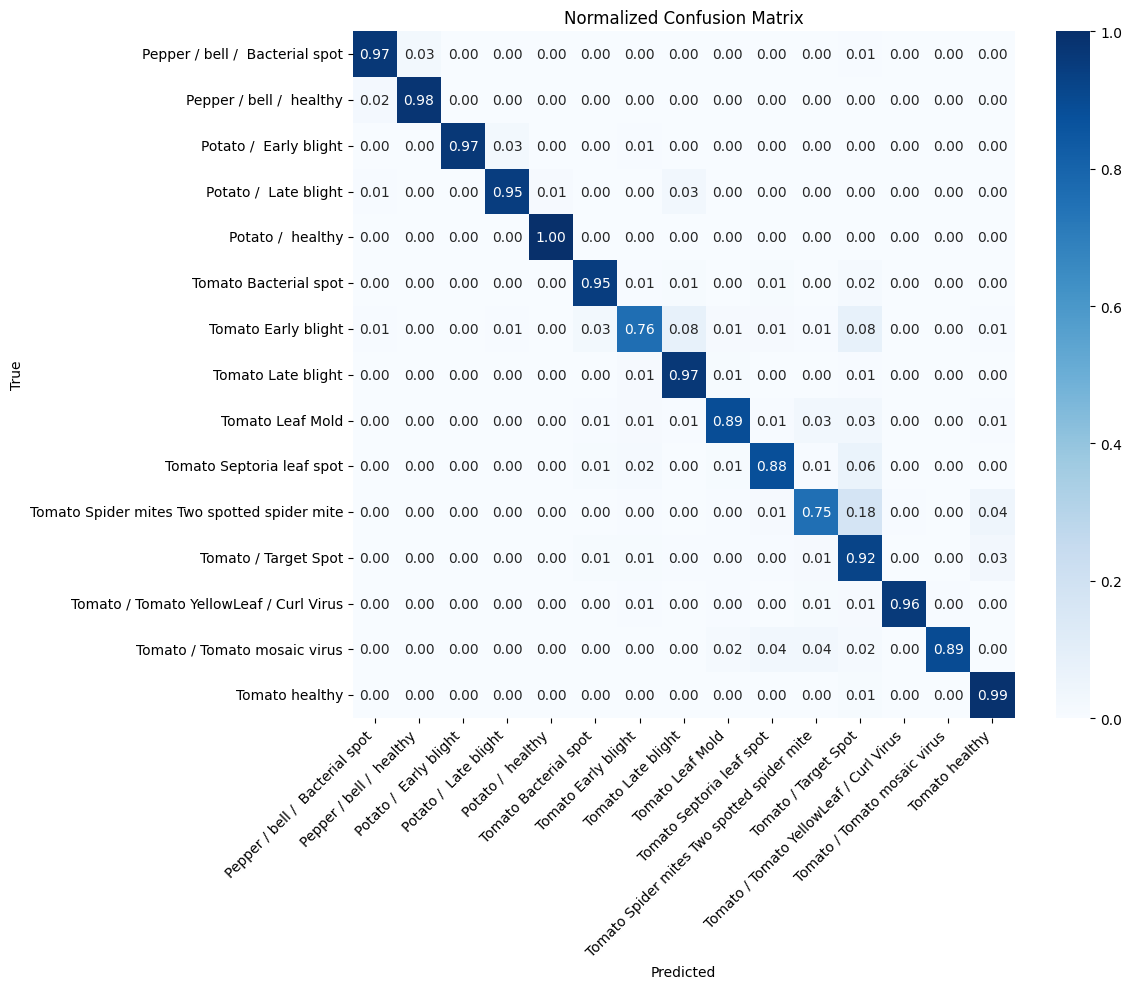

                                             precision    recall  f1-score   support

            Pepper / bell /  Bacterial spot      0.942     0.967     0.954       151
                   Pepper / bell /  healthy      0.982     0.978     0.980       223
                     Potato /  Early blight      0.993     0.967     0.980       150
                      Potato /  Late blight      0.953     0.947     0.950       150
                          Potato /  healthy      0.923     1.000     0.960        24
                      Tomato Bacterial spot      0.968     0.947     0.957       320
                        Tomato Early blight      0.851     0.760     0.803       150
                         Tomato Late blight      0.923     0.965     0.944       287
                           Tomato Leaf Mold      0.908     0.889     0.898       144
                  Tomato Septoria leaf spot      0.951     0.880     0.914       267
Tomato Spider mites Two spotted spider mite      0.918     0.754

In [ ]:
probs = model.predict(test_dataset, verbose=0)
if probs.ndim == 2:
    y_pred = probs.argmax(axis=1)
else:
    y_pred = probs.astype(int)

y_true = test_dataset.classes
class_names = list(test_dataset.class_indices.keys())
pretty = [c.replace('__',' / ').replace('_',' ') for c in class_names]

cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(12,10))
sns.heatmap(cm_norm, annot=True, fmt=".2f",
            xticklabels=pretty, yticklabels=pretty, cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Normalized Confusion Matrix")
plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
plt.tight_layout(); plt.show()

print(classification_report(y_true, y_pred, target_names=pretty, digits=3))


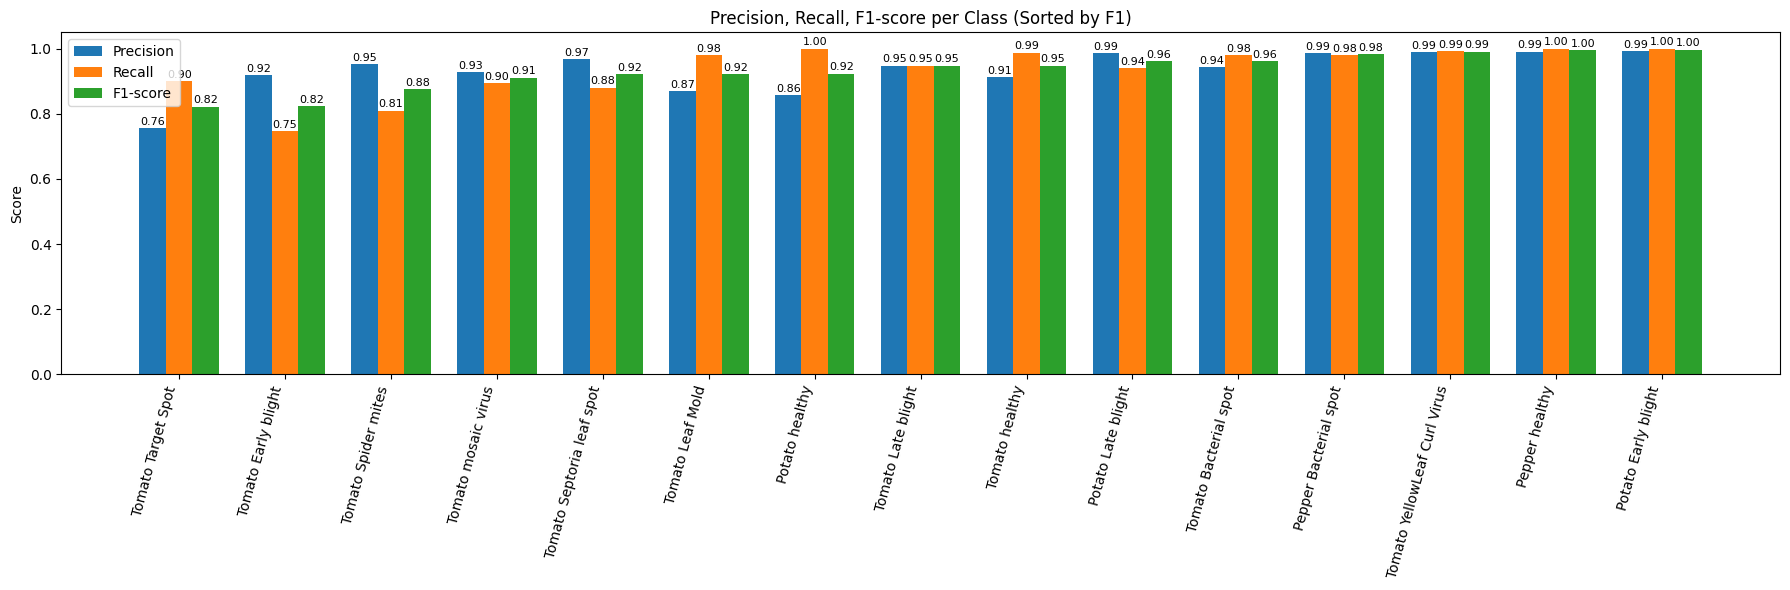

In [ ]:
data = {
    "Class": [
        "Pepper Bacterial spot","Pepper healthy","Potato Early blight","Potato Late blight",
        "Potato healthy","Tomato Bacterial spot","Tomato Early blight","Tomato Late blight",
        "Tomato Leaf Mold","Tomato Septoria leaf spot","Tomato Spider mites",
        "Tomato Target Spot","Tomato YellowLeaf Curl Virus","Tomato mosaic virus","Tomato healthy"
    ],
    "Precision": [0.987,0.991,0.993,0.986,0.857,0.943,0.918,0.948,0.870,0.967,0.953,0.755,0.990,0.927,0.912],
    "Recall":    [0.980,1.000,1.000,0.940,1.000,0.981,0.747,0.948,0.979,0.880,0.810,0.901,0.992,0.895,0.988],
    "F1-score":  [0.983,0.996,0.997,0.962,0.923,0.962,0.824,0.948,0.922,0.922,0.876,0.822,0.991,0.911,0.948]
}

df = pd.DataFrame(data)
df = df.sort_values(by="F1-score")
x = np.arange(len(df))
width = 0.25

plt.figure(figsize=(18,6))
plt.bar(x - width, df["Precision"], width, label="Precision", color="#1f77b4")
plt.bar(x, df["Recall"], width, label="Recall", color="#ff7f0e")
plt.bar(x + width, df["F1-score"], width, label="F1-score", color="#2ca02c")

plt.xticks(x, df["Class"], rotation=75, ha="right")
plt.ylabel("Score")
plt.title("Precision, Recall, F1-score per Class (Sorted by F1)")
plt.legend()
for i in range(len(df)):
    plt.text(i - width, df["Precision"].iloc[i] + 0.01, f"{df['Precision'].iloc[i]:.2f}", ha="center", fontsize=8)
    plt.text(i, df["Recall"].iloc[i] + 0.01, f"{df['Recall'].iloc[i]:.2f}", ha="center", fontsize=8)
    plt.text(i + width, df["F1-score"].iloc[i] + 0.01, f"{df['F1-score'].iloc[i]:.2f}", ha="center", fontsize=8)

plt.tight_layout()
plt.show()
